In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.style.use('ggplot')

import tensorflow as tf
%load_ext tensorboard

import warnings
warnings.filterwarnings('ignore')

import os
import datetime as dt

In [2]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow import keras
from tensorflow.keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import time
import math

In [3]:
data = pd.read_csv("D:\Final Year Project\Dataset\Proposed Paper Dataset\S&P 500\gspc_high_low.csv")
data.head()

,Date,Open,High,Low,Close,SAR,MACD,RSI,ATR,MFI,USDX,VIX,EFFR,UNRATE,UMSCENT
0,03-01-2006,1248.290039,1270.219971,1245.739990,1268.800049,NaN,0.000000,NaN,NaN,NaN,89.839996,11.14,4.34,4.7,91.2
1,04-01-2006,1268.800049,1275.369995,1267.739990,1273.459961,1245.73999,0.196947,NaN,NaN,NaN,89.139999,11.37,4.22,4.7,91.2
2,05-01-2006,1273.459961,1276.910034,1270.300049,1273.479980,1245.73999,0.371553,NaN,NaN,NaN,89.330002,11.31,4.24,4.7,91.2
3,06-01-2006,1273.479980,1286.089966,1273.479980,1285.449951,1245.73999,1.030907,NaN,NaN,NaN,88.849998,11.00,4.22,4.7,91.2
4,09-01-2006,1285.449951,1290.780029,1284.819946,1290.150024,1245.73999,1.810155,NaN,NaN,NaN,89.250000,11.13,4.25,4.7,91.2


In [4]:
data.isna().sum()

Date        0
Open        0
High        0
Low         0
Close       0
SAR         1
MACD        0
RSI         8
ATR        49
MFI        29
USDX        2
VIX         0
EFFR       35
UNRATE      0
UMSCENT     0
dtype: int64

In [5]:
data.drop(data.index[:49], inplace=True)
data.reset_index(drop=True, inplace=True)
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
data.set_index("Date",inplace=True)
data.head()

,Open,High,Low,Close,SAR,MACD,RSI,ATR,MFI,USDX,VIX,EFFR,UNRATE,UMSCENT
Date,,,,,,,,,,,,,,
2006-03-15,1297.479980,1304.400024,1294.969971,1303.020020,1245.73999,4.059285,63.124058,10.392993,56.832217,89.699997,11.35,4.47,4.7,88.9
2006-03-16,1303.020020,1310.449951,1303.020020,1305.329956,1245.73999,4.826013,66.985742,10.051992,56.670295,89.070000,11.98,4.55,4.7,88.9
2006-03-17,1305.329956,1309.790039,1305.319946,1307.250000,1245.73999,5.571365,81.354102,9.988794,60.493283,88.919998,12.12,4.60,4.7,88.9
2006-03-20,1307.250000,1310.000000,1303.589966,1305.079956,1245.73999,6.122679,81.725270,9.984795,60.708410,89.129997,11.79,4.55,4.7,88.9
2006-03-21,1305.079956,1310.880005,1295.819946,1297.229980,1245.73999,6.260491,68.291731,10.033796,60.639310,89.620003,11.62,4.54,4.7,88.9


In [6]:
data = data.fillna(data.mean())
data.isna().sum()

Open       0
High       0
Low        0
Close      0
SAR        0
MACD       0
RSI        0
ATR        0
MFI        0
USDX       0
VIX        0
EFFR       0
UNRATE     0
UMSCENT    0
dtype: int64

In [7]:
print("Column Names : ")
count=0
for column in data.columns:
    print(column)
    count+=1
print("Total no of columns in dataset = "+str(count))

Column Names : 
Open
High
Low
Close
SAR
MACD
RSI
ATR
MFI
USDX
VIX
EFFR
UNRATE
UMSCENT
Total no of columns in dataset = 14


In [8]:
data.dtypes

Open       float64
High       float64
Low        float64
Close      float64
SAR        float64
MACD       float64
RSI        float64
ATR        float64
MFI        float64
USDX       float64
VIX        float64
EFFR       float64
UNRATE     float64
UMSCENT    float64
dtype: object

In [9]:
data.describe()

,Open,High,Low,Close,SAR,MACD,RSI,ATR,MFI,USDX,VIX,EFFR,UNRATE,UMSCENT
count,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000
mean,2215.602655,2228.380603,2201.879209,2215.995963,989.352357,9.961819,55.994301,28.674883,53.891476,88.777090,19.870871,1.299982,6.016352,80.222766
std,1060.553331,1066.206959,1054.627175,1060.725848,404.539485,36.226028,19.770110,20.503058,10.139617,9.272771,9.110330,1.721908,2.205442,13.047978
min,679.280029,695.270019,666.789978,676.530029,666.789978,-212.441916,0.000000,8.880007,22.365246,71.330002,9.140000,0.040000,3.400000,50.000000
25%,1340.199951,1349.439941,1331.469971,1340.199951,666.789978,-2.658452,42.061798,14.784806,46.742932,80.480003,13.740000,0.100000,4.300000,70.600000
50%,1976.930054,1985.170044,1967.310059,1978.089966,666.789978,14.138794,56.496934,20.522988,53.825806,89.129997,17.500000,0.200000,5.100000,80.900000
75%,2854.649902,2868.879883,2834.969971,2853.580078,1576.089966,25.995324,70.086803,35.086426,61.071333,96.570000,23.110001,1.990000,7.800000,91.900000
max,4804.509766,4818.620117,4780.040039,4796.560059,1576.089966,107.397605,99.566735,123.041602,89.979368,114.110001,82.690002,5.410000,14.700000,101.400000


In [10]:
df = data.copy()
len(df)

4397

In [11]:
df.head()

,Open,High,Low,Close,SAR,MACD,RSI,ATR,MFI,USDX,VIX,EFFR,UNRATE,UMSCENT
Date,,,,,,,,,,,,,,
2006-03-15,1297.479980,1304.400024,1294.969971,1303.020020,1245.73999,4.059285,63.124058,10.392993,56.832217,89.699997,11.35,4.47,4.7,88.9
2006-03-16,1303.020020,1310.449951,1303.020020,1305.329956,1245.73999,4.826013,66.985742,10.051992,56.670295,89.070000,11.98,4.55,4.7,88.9
2006-03-17,1305.329956,1309.790039,1305.319946,1307.250000,1245.73999,5.571365,81.354102,9.988794,60.493283,88.919998,12.12,4.60,4.7,88.9
2006-03-20,1307.250000,1310.000000,1303.589966,1305.079956,1245.73999,6.122679,81.725270,9.984795,60.708410,89.129997,11.79,4.55,4.7,88.9
2006-03-21,1305.079956,1310.880005,1295.819946,1297.229980,1245.73999,6.260491,68.291731,10.033796,60.639310,89.620003,11.62,4.54,4.7,88.9


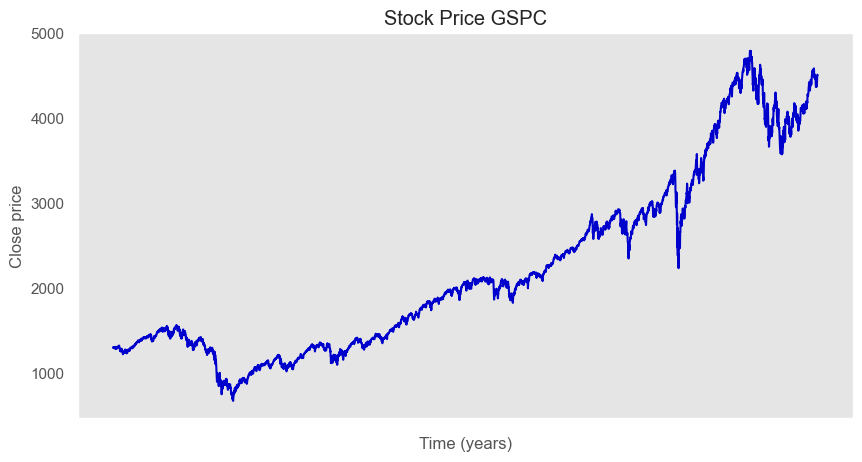

In [12]:
close = df['Close']

fig = plt.figure(figsize=(10,5))
fig.set(facecolor = "white")
plt.plot(close, 'mediumblue',label=['S&P 500 Close Price'])
plt.gca().set_xticklabels([])
plt.grid(False)

plt.title('Stock Price GSPC')
plt.xlabel('Time (years)')
plt.ylabel('Close price')
plt.show()

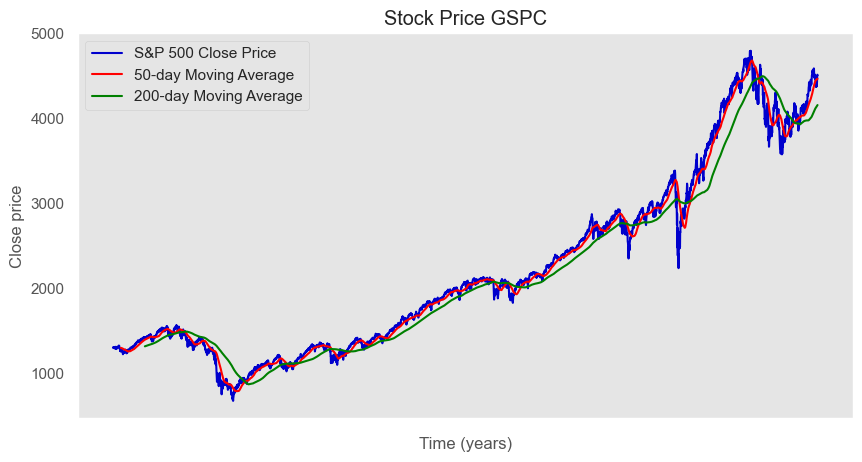

In [13]:
df['MA_50'] = df['Close'].rolling(50).mean()
df['MA_200'] = df['Close'].rolling(200).mean()

fig = plt.figure(figsize=(10,5))
fig.set(facecolor = "white")
plt.plot(df['Close'], 'mediumblue',label=['S&P 500 Close Price'])
plt.plot(df['MA_50'],'red', label=['50-day MA'])
plt.plot(df['MA_200'],'green', label=['200-day MA'])
plt.legend(['S&P 500 Close Price', '50-day Moving Average', '200-day Moving Average'], loc='upper left')

plt.gca().set_xticklabels([])
plt.grid(False)

plt.title('Stock Price GSPC')
plt.xlabel('Time (years)')
plt.ylabel('Close price')
plt.show()

In [14]:
data.head()

,Open,High,Low,Close,SAR,MACD,RSI,ATR,MFI,USDX,VIX,EFFR,UNRATE,UMSCENT
Date,,,,,,,,,,,,,,
2006-03-15,1297.479980,1304.400024,1294.969971,1303.020020,1245.73999,4.059285,63.124058,10.392993,56.832217,89.699997,11.35,4.47,4.7,88.9
2006-03-16,1303.020020,1310.449951,1303.020020,1305.329956,1245.73999,4.826013,66.985742,10.051992,56.670295,89.070000,11.98,4.55,4.7,88.9
2006-03-17,1305.329956,1309.790039,1305.319946,1307.250000,1245.73999,5.571365,81.354102,9.988794,60.493283,88.919998,12.12,4.60,4.7,88.9
2006-03-20,1307.250000,1310.000000,1303.589966,1305.079956,1245.73999,6.122679,81.725270,9.984795,60.708410,89.129997,11.79,4.55,4.7,88.9
2006-03-21,1305.079956,1310.880005,1295.819946,1297.229980,1245.73999,6.260491,68.291731,10.033796,60.639310,89.620003,11.62,4.54,4.7,88.9


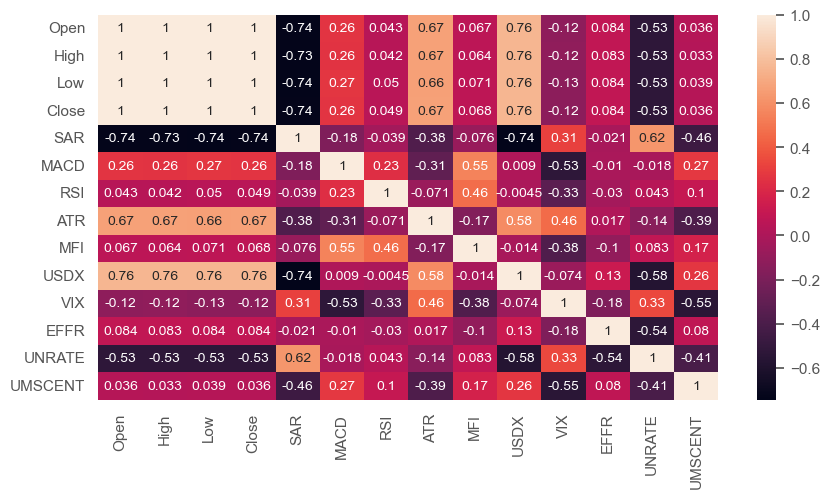

In [15]:
fig = plt.figure(figsize= (10,5))
sns.heatmap(data.corr(), annot=True)
sns.set_style("whitegrid")
plt.show()

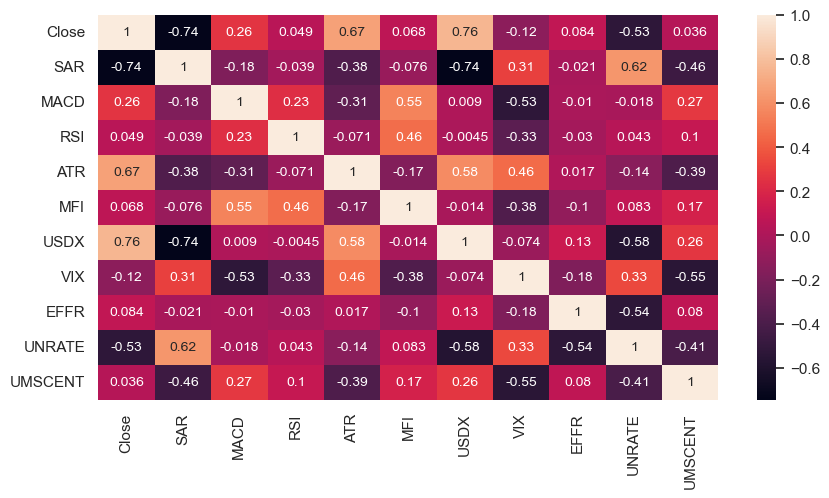

In [16]:
data = data.iloc[:, 3:]
fig = plt.figure(figsize= (10,5))
sns.heatmap(data.corr(), annot=True)
sns.set_style("whitegrid")
plt.show()

<Figure size 2000x1200 with 0 Axes>

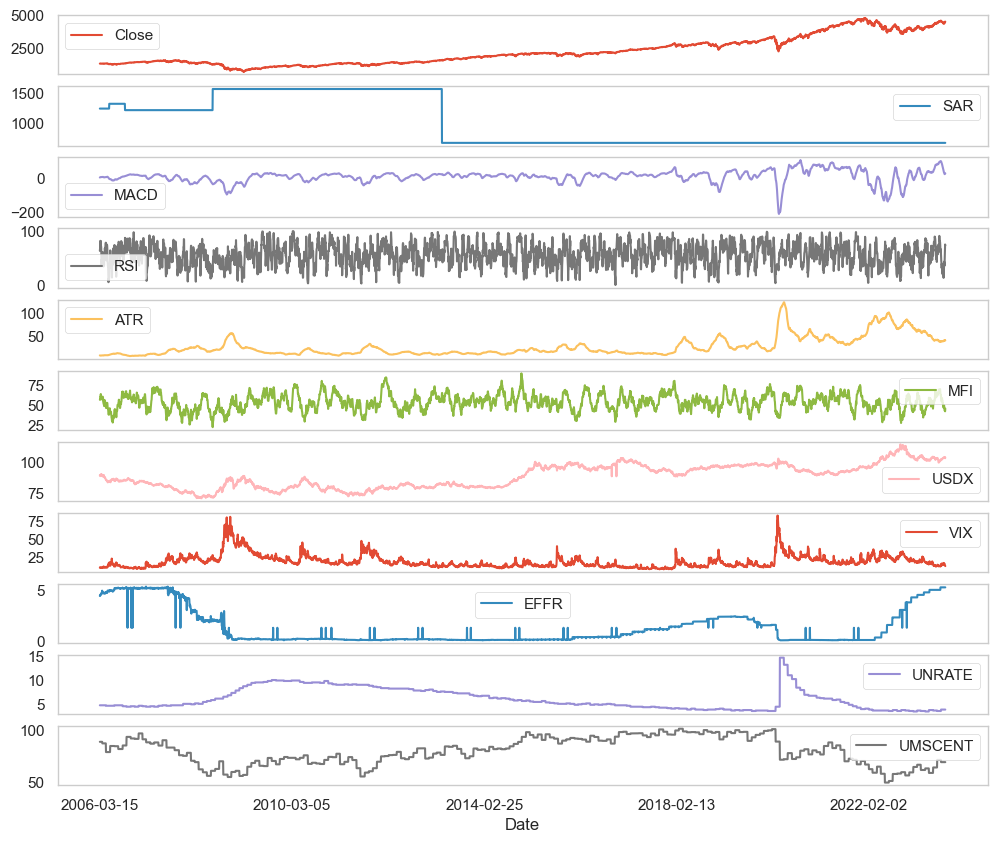

In [17]:
fig = plt.figure(figsize = (20, 12))
data.plot(subplots = True, figsize = (12,10),grid=False)
sns.set_style("whitegrid")
plt.show()

In [18]:
data.describe()

,Close,SAR,MACD,RSI,ATR,MFI,USDX,VIX,EFFR,UNRATE,UMSCENT
count,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000,4397.000000
mean,2215.995963,989.352357,9.961819,55.994301,28.674883,53.891476,88.777090,19.870871,1.299982,6.016352,80.222766
std,1060.725848,404.539485,36.226028,19.770110,20.503058,10.139617,9.272771,9.110330,1.721908,2.205442,13.047978
min,676.530029,666.789978,-212.441916,0.000000,8.880007,22.365246,71.330002,9.140000,0.040000,3.400000,50.000000
25%,1340.199951,666.789978,-2.658452,42.061798,14.784806,46.742932,80.480003,13.740000,0.100000,4.300000,70.600000
50%,1978.089966,666.789978,14.138794,56.496934,20.522988,53.825806,89.129997,17.500000,0.200000,5.100000,80.900000
75%,2853.580078,1576.089966,25.995324,70.086803,35.086426,61.071333,96.570000,23.110001,1.990000,7.800000,91.900000
max,4796.560059,1576.089966,107.397605,99.566735,123.041602,89.979368,114.110001,82.690002,5.410000,14.700000,101.400000


In [19]:
from skimage.restoration import (denoise_wavelet, estimate_sigma)

data['Close']= denoise_wavelet(data.iloc[:, 0], wavelet='haar',
                                      method='VisuShrink',
                                      mode='soft', rescale_sigma = True)
data.head()

,Close,SAR,MACD,RSI,ATR,MFI,USDX,VIX,EFFR,UNRATE,UMSCENT
Date,,,,,,,,,,,
2006-03-15,1297.479562,1245.73999,4.059285,63.124058,10.392993,56.832217,89.699997,11.35,4.47,4.7,88.9
2006-03-16,1297.479562,1245.73999,4.826013,66.985742,10.051992,56.670295,89.070000,11.98,4.55,4.7,88.9
2006-03-17,1297.479562,1245.73999,5.571365,81.354102,9.988794,60.493283,88.919998,12.12,4.60,4.7,88.9
2006-03-20,1297.479562,1245.73999,6.122679,81.725270,9.984795,60.708410,89.129997,11.79,4.55,4.7,88.9
2006-03-21,1297.479562,1245.73999,6.260491,68.291731,10.033796,60.639310,89.620003,11.62,4.54,4.7,88.9


In [20]:
def mean_absolute_percentage_error(y_true, y_pred):
    return (np.mean(np.abs((y_true - y_pred)/(y_true))*100))

def calculate_scores(y_true, y_pred):
  mae = mean_absolute_error(y_true, y_pred)
  mape = mean_absolute_percentage_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  R = np.corrcoef(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)

  print(f"Mean Absolute Error (MAE): {mae:.4f}")
  print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
  print(f"Mean Squared Error (MSE): {mse:.4f}")
  print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
  print(f"R-Pearson Correlation Coefficient (R): {R[0,1]:.4f}")
  print(f"R-squared (R2): {r2:.4f}")
  dic = {'rmse':rmse, 'R': R[0,1], 'mape': mape}
  return (dic)

In [21]:
def DatasetCreation(dataset, time_step = 1):
   DataX, DataY = [], []
   for i in range(len(dataset)- time_step -1):
         a = dataset[i:(i+ time_step), ]
         DataX.append(a)
         DataY.append(dataset[i + time_step, 0]) 
   return np.array(DataX), np.array(DataY)


def data_split(data, split = 0.2):
  l1   = int(len(data) * (1- split))
  l2    = len(data) - l1
  data1  = data.iloc[0:l1,:]
  data2   = data.iloc[l1:len(data),:]
  return data1, data2

def min_max_transform(data, feature_range=(0, 1)):
   scaler = MinMaxScaler(feature_range)
   return scaler.fit_transform(data)

def min_max_inverse_transform(data_scaled, min_original, max_original):
    return min_original +  data_scaled*(max_original - min_original)

In [22]:
def true_pred_plot(model_output):

  y_train = model_output['datasets']['y_train']
  y_test =  model_output['datasets']['y_test']

  train_pred = model_output['best_model']['train_predictions']
  test_pred = model_output['best_model']['test_predictions']

  fig = plt.figure(figsize= (14,5))
  plt.subplot(121)
  plt.scatter(y_train, train_pred, marker= "+", color = 'mediumblue')
  identity_line = np.linspace(max(min(y_train), min(train_pred)), min(max(y_train), max(train_pred)))
  plt.plot(identity_line, identity_line, color="red", linestyle="dashed", linewidth= 2.5)
  plt.xlabel("True")
  plt.ylabel("Predicted")
  plt.title("Training data (a)")

  plt.subplot(122)
  plt.scatter(y_test, test_pred, marker = "+", color = 'mediumblue')
  identity_line = np.linspace(max(min(y_test), min(test_pred)), min(max(y_test), max(test_pred)))
  plt.plot(identity_line, identity_line, color="red", linestyle="dashed", linewidth= 2.5)
  plt.xlabel("True")
  plt.ylabel("Predicted")
  plt.title("Test data (b)")

  plt.suptitle("Scatter plot of True vs Predicted Close prices")
  plt.show()


def best_model_prediction_plot(model_output):

  time_step =  model_output['hyper_parameters']['time_step']

  data = model_output['datasets']['data']

  train_predict_plot_data = np.empty_like(data.values[:,0])# extracting closing price
  train_predict_plot_data[:] = np.nan

  test_predict_plot_data = np.empty_like(data.values[:,0])
  test_predict_plot_data[:] = np.nan

  fig = plt.figure(figsize = (14,5))

  plt.subplot(121)

  train_pred = model_output['best_model']['train_predictions']
  test_pred = model_output['best_model']['test_predictions']

  train_predict_plot_data[time_step:len(train_pred)+ time_step] =  train_pred
  test_predict_plot_data[len(train_pred)+(time_step*2)+1:len(data.values)-1] = test_pred

  plt.plot(data.values[:,0],'k', linewidth = 1.5)
  plt.plot(train_predict_plot_data,'mediumblue',linewidth = 1.5)
  plt.plot(test_predict_plot_data,'darkgreen',linewidth = 1.5)
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(a)")
  plt.legend(['True value', 'Predicted value in train set', 'Predicted value in test set'], loc = 'upper left')

  plt.subplot(122)
  plt.plot(data.values[len(train_pred)+(time_step*2)+1:-1, 0],'k',linewidth = 1.5)
  plt.plot(test_pred,'darkgreen',linewidth = 1.5)
  plt.xlabel('')
  plt.ylabel('Close price')
  plt.title("(b)")
  plt.legend(['True value', 'Predicted value'], loc='upper left')


In [23]:
def create_visualization(model_output):
  print("==================== Scatter Plot ==========================")
  true_pred_plot(model_output)
  print("==================== Line Plot ==========================")
  best_model_prediction_plot(model_output)

In [24]:
def build_model(layers, time_step, num_features, optimizer = 'Adam', learning_rate = 0.001, verbose = 1):

  model = Sequential()

  for i in range(len(layers)):
    if len(layers)==1:
      model.add(LSTM(int(layers[i]), input_shape = (time_step, num_features)))
    else:
      if i < len(layers)-1:
        if i == 0:
          model.add(LSTM(int(layers[i]), input_shape=(time_step, num_features), return_sequences= True))
        else:
          model.add(LSTM(int(layers[i]), return_sequences=True))
      else:
        model.add(LSTM(int(layers[i])))
  model.add(Dense(1, activation = 'linear'))

  if optimizer == 'Adam':
    opt = optimizers.Adam(learning_rate = learning_rate)
  elif optimizer == 'Adagrad':
    opt = optimizers.Adagrad(learning_rate = learning_rate)
  elif optimizer == 'Nadam':
    opt = optimizers.Nadam(learning_rate = learning_rate)
  elif optimizer == 'Adadelta':
    opt = optimizers.Adadelta(learning_rate= learning_rate)
  elif optimizer == 'RMSprop':
    opt = optimizers.RMSprop(learning_rate= learning_rate)
  else:
    print("No optimizer found in the list(['Adam', 'Adagrad','Nadam', 'Adadelta', 'RMSprop'])! Please apply your optimizer manually...")

  model.compile(loss='mean_squared_error', optimizer= opt)

  if verbose == 1:
    print(model.summary())
  return model

In [25]:
optimizers_names = ['Adam', 'Adagrad', 'Nadam']

build_model([250], 5, 10, optimizers_names[2], 0.001, 1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 250)               261000    
                                                                 
 dense (Dense)               (None, 1)                 251       
                                                                 
Total params: 261251 (1020.51 KB)
Trainable params: 261251 (1020.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [26]:
def single_layer_LSTM(neurons, hyper_parameters, data, time_step = 5, test_split = 0.2, epochs = 20,  num_replicates = 2):

  print("Progress: Performing data preparation steps.......\n")

  train_data, test_data = data_split(data, test_split)
  num_features = train_data.shape[1]

  min_train, max_train  = train_data["Close"].min(), train_data["Close"].max()
  min_test, max_test   =  test_data["Close"].min(), test_data["Close"].max()

  train_data_scaled  =  min_max_transform(train_data)
  test_data_scaled   = min_max_transform(test_data)

  X_train, y_train  =   DatasetCreation(train_data_scaled, time_step)
  X_test, y_test    =   DatasetCreation(test_data_scaled, time_step)

  y_train_original  =  min_max_inverse_transform(y_train, min_train, max_train)
  y_test_original  =  min_max_inverse_transform(y_test, min_test, max_test)

  print("Progress: Building and training models.......\n")

  neurons = np.array(neurons)
  rmse_array = np.zeros((len(neurons), num_replicates))
  mape_array = np.zeros((len(neurons), num_replicates))
  R_array    = np.zeros((len(neurons), num_replicates))
  elapsed_time_array = np.zeros((len(neurons), num_replicates))
  models_history = []

  train_predictions = []
  test_predictions  = []

  for i in range(len(neurons)):

    print("Model hyperparameters used: \n ", hyper_parameters[i])
    model_history_per_replicate = []
    train_predictions_per_replicate = []
    test_predictions_per_replicate  = []

    hidden_nodes = int(neurons[i])

    for k in range(num_replicates):

      print("Program is running for %d neurons and %d replicate ----->\n" %(hidden_nodes, k))

      layers = [hidden_nodes]

      model = build_model(layers, time_step, num_features, optimizer = hyper_parameters[i][0], learning_rate = hyper_parameters[i][1], verbose = 0)
      callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience= 5)

      start = time.time()
      history = model.fit(X_train, y_train, batch_size = hyper_parameters[i][2], epochs= epochs, callbacks=[callback], verbose = 1)

      model.save("optimized_single_layer_model_"+str(k)+".h5")
    
      plt.figure(figsize=(8, 5))
      plt.plot(history.history['loss'])
      plt.title('Epoch vs. Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.grid(True)
      plt.show()
    
      end = time.time()
      elapsed_time = end - start

      model_history_per_replicate.append(history)

      train_pred   =  min_max_inverse_transform(model.predict(X_train).ravel(), min_train, max_train)
      test_pred    =  min_max_inverse_transform(model.predict(X_test).ravel(), min_test, max_test)

      train_predictions_per_replicate.append(train_pred)
      test_predictions_per_replicate.append(test_pred)

      scores =   calculate_scores(min_max_inverse_transform(y_test, min_test, max_test),test_pred)

      rmse_array[i][k] = scores['rmse']
      mape_array[i][k] =  scores['mape']
      R_array[i][k] = scores['R']
      elapsed_time_array[i][k] = elapsed_time

    models_history.append(model_history_per_replicate)
    train_predictions.append(train_predictions_per_replicate)
    test_predictions.append(test_predictions_per_replicate)

  print("Progress: Collecting outputs.......\n")


  neurons_df = pd.DataFrame(neurons)
  rmse_df = pd.DataFrame(rmse_array)
  mape_df  = pd.DataFrame(mape_array)
  R_df    = pd.DataFrame(R_array)
  elapsed_time_df =  pd.DataFrame(elapsed_time_array)

  train_predictions  = np.array(train_predictions)
  test_predictions   = np.array(test_predictions)

  min_index = pd.DataFrame(rmse_df.min(axis = 1)).idxmin()[0]
  min_col =   pd.DataFrame(rmse_df.min(axis = 0)).idxmin()[0]

  num_neurons_with_best_rmse = neurons_df.loc[min_index,0]

  best_rmse = rmse_df.loc[min_index, min_col]
  mape_with_best_rmse = mape_df.loc[min_index, min_col]
  R_with_best_rmse =  R_df.loc[min_index, min_col]
  elapsed_time_with_best_rmse = elapsed_time_df.loc[min_index, min_col]

  train_predictions_with_best_rmse = train_predictions[min_index][min_col]
  test_predictions_with_best_rmse = test_predictions[min_index][min_col]

  loss_with_best_rmse = models_history[min_index][min_col].history['loss']

  hyper_parameters = { 'neurons': neurons,
                       'model_specific_hyper_parameters': hyper_parameters,#additional best_hyper_parmeters for each models
                       'epochs': epochs,
                       'time_step':time_step,
                       'num_replicates': num_replicates,
                       'test_split':test_split
                        }
  scores = {'neurons': neurons_df, 'rmse': rmse_df, 'mape': mape_df, 'R': R_df, 'elapsed_time': elapsed_time_df}
  avg_scores = pd.DataFrame({'neurons': neurons,
                            'rmse': rmse_df.mean(axis = 1),
                            'mape': mape_df.mean(axis = 1),
                            'R': R_df.mean(axis = 1),
                            'elapsed_time': elapsed_time_df.mean(axis = 1)})
  all_stds = pd.DataFrame({'neurons': neurons,
                            'rmse': rmse_df.std(axis = 1),
                            'mape': mape_df.std(axis = 1),
                            'R': R_df.std(axis = 1),
                            'elapsed_time': elapsed_time_df.std(axis = 1)})
  all_minimums = pd.DataFrame({'neurons': neurons,
                            'rmse': rmse_df.min(axis = 1),
                            'mape': mape_df.min(axis = 1),
                            'R': R_df.min(axis = 1),
                            'elapsed_time': elapsed_time_df.min(axis = 1)})
  all_maximums = pd.DataFrame({'neurons': neurons,
                            'rmse': rmse_df.max(axis = 1),
                            'mape': mape_df.max(axis = 1),
                            'R': R_df.max(axis = 1),
                            'elapsed_time': elapsed_time_df.max(axis = 1)})
  model_with_best_rmse = {  'neurons': num_neurons_with_best_rmse,
                            'replicate': min_col,
                            'rmse': best_rmse,
                            'mape': mape_with_best_rmse,
                            'R':  R_with_best_rmse,
                            'elapsed_time': elapsed_time_with_best_rmse,
                            'train_predictions':train_predictions_with_best_rmse,
                            'test_predictions': test_predictions_with_best_rmse,
                            'loss':loss_with_best_rmse,

                         }

  datasets  =    {'data': data,
                  'X_train': X_train,
                  'X_test': X_test,
                  'y_train': y_train_original,
                  'y_test': y_test_original
                  }


  print("\nProgress: All works are done successfully, congratulations!!\n")

  print("\nBest model (neurons, replicate, rmse): ", num_neurons_with_best_rmse, min_col, best_rmse)
  print('\nAverage scores:\n', avg_scores)
  print('\nStandard_deviations:\n', all_stds)
  print('\nMinimums:\n', all_minimums)
  print('\nMaximums:\n', all_maximums)

  output_dictionary = { 'hyper_parameters': hyper_parameters,
                        'best_model': model_with_best_rmse,
                        'scores': scores,
                        'avg_scores': avg_scores,
                        'all_stds': all_stds,
                        'all_minimums': all_minimums,
                        'all_maximums': all_maximums,
                        'train_predictions': train_predictions,
                        'test_predictions':  test_predictions,
                        'models_history': models_history,
                        'datasets': datasets
                       }

  return (output_dictionary)

In [60]:
neurons = 86
optimizer = "Nadam"
learning_rate = 0.001
batch_size = 8

Progress: Performing data preparation steps.......

Progress: Building and training models.......

Model hyperparameters used: 
  ['Nadam', 0.001, 8]
Program is running for 86 neurons and 0 replicate ----->

Epoch 1/100
439/439 [==============================] - 6s 6ms/step - loss: 0.0037
Epoch 2/100
439/439 [==============================] - 3s 6ms/step - loss: 1.3189e-04
Epoch 3/100
439/439 [==============================] - 2s 6ms/step - loss: 1.0151e-04
Epoch 4/100
439/439 [==============================] - 3s 6ms/step - loss: 9.1381e-05
Epoch 5/100
439/439 [==============================] - 2s 5ms/step - loss: 8.5961e-05
Epoch 6/100
439/439 [==============================] - 3s 7ms/step - loss: 9.2925e-05
Epoch 7/100
439/439 [==============================] - 2s 6ms/step - loss: 8.5914e-05
Epoch 8/100
439/439 [==============================] - 2s 5ms/step - loss: 8.3371e-05
Epoch 9/100
439/439 [==============================] - 2s 6ms/step - loss: 7.4287e-05
Epoch 10/100
439/439 [

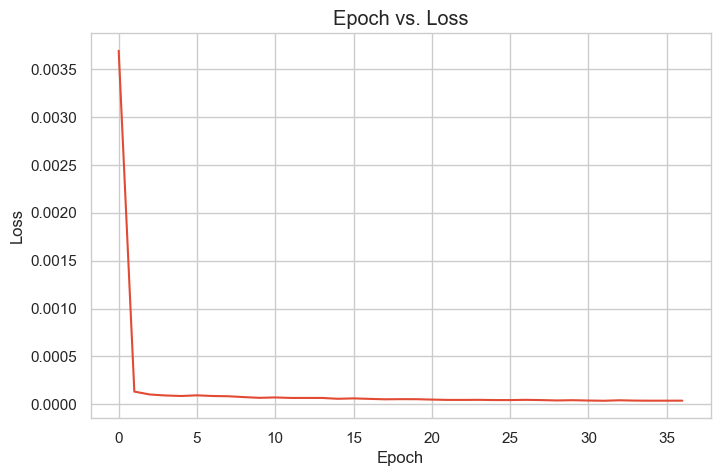

28/28 [==============================] - 0s 4ms/step
Mean Absolute Error (MAE): 26.6633
Mean Absolute Percentage Error (MAPE): 0.7136
Mean Squared Error (MSE): 1669.3619
Root Mean Squared Error (RMSE): 40.8578
R-Pearson Correlation Coefficient (R): 0.9971
R-squared (R2): 0.9934
Program is running for 86 neurons and 1 replicate ----->

Epoch 1/100
439/439 [==============================] - 5s 5ms/step - loss: 0.0016
Epoch 2/100
439/439 [==============================] - 2s 5ms/step - loss: 1.0752e-04
Epoch 3/100
439/439 [==============================] - 2s 5ms/step - loss: 9.2826e-05
Epoch 4/100
439/439 [==============================] - 2s 5ms/step - loss: 8.8781e-05
Epoch 5/100
439/439 [==============================] - 2s 6ms/step - loss: 8.2643e-05
Epoch 6/100
439/439 [==============================] - 2s 5ms/step - loss: 8.3438e-05
Epoch 7/100
439/439 [==============================] - 2s 5ms/step - loss: 8.1191e-05
Epoch 8/100
439/439 [==============================] - 2s 6ms/ste

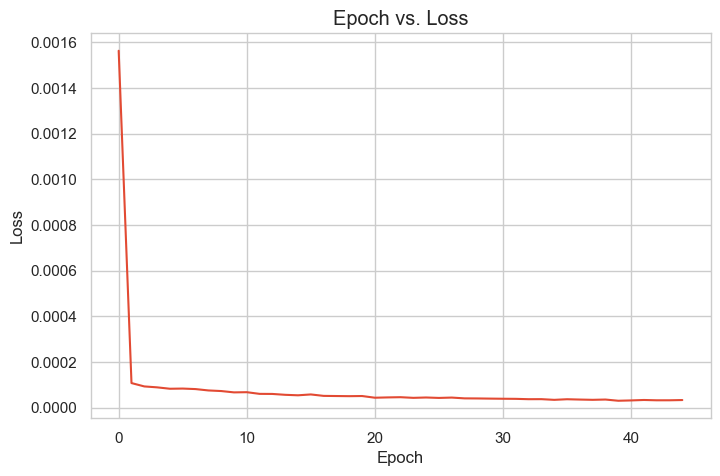

28/28 [==============================] - 0s 4ms/step
Mean Absolute Error (MAE): 24.6532
Mean Absolute Percentage Error (MAPE): 0.6555
Mean Squared Error (MSE): 1472.8323
Root Mean Squared Error (RMSE): 38.3775
R-Pearson Correlation Coefficient (R): 0.9971
R-squared (R2): 0.9942
Program is running for 86 neurons and 2 replicate ----->

Epoch 1/100
439/439 [==============================] - 6s 5ms/step - loss: 0.0036
Epoch 2/100
439/439 [==============================] - 2s 5ms/step - loss: 1.2322e-04
Epoch 3/100
439/439 [==============================] - 2s 5ms/step - loss: 1.1341e-04
Epoch 4/100
439/439 [==============================] - 2s 5ms/step - loss: 1.0058e-04
Epoch 5/100
439/439 [==============================] - 2s 5ms/step - loss: 9.7326e-05
Epoch 6/100
439/439 [==============================] - 2s 5ms/step - loss: 9.0754e-05
Epoch 7/100
439/439 [==============================] - 2s 5ms/step - loss: 7.9050e-05
Epoch 8/100
439/439 [==============================] - 2s 5ms/ste

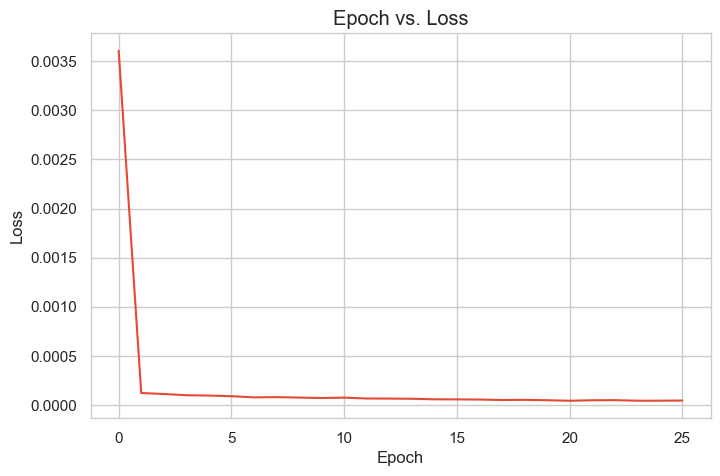

28/28 [==============================] - 0s 4ms/step
Mean Absolute Error (MAE): 29.5895
Mean Absolute Percentage Error (MAPE): 0.7899
Mean Squared Error (MSE): 1980.7502
Root Mean Squared Error (RMSE): 44.5056
R-Pearson Correlation Coefficient (R): 0.9961
R-squared (R2): 0.9921
Program is running for 86 neurons and 3 replicate ----->

Epoch 1/100
439/439 [==============================] - 5s 5ms/step - loss: 0.0026
Epoch 2/100
439/439 [==============================] - 2s 5ms/step - loss: 9.6079e-05
Epoch 3/100
439/439 [==============================] - 2s 5ms/step - loss: 8.8154e-05
Epoch 4/100
439/439 [==============================] - 2s 5ms/step - loss: 9.5745e-05
Epoch 5/100
439/439 [==============================] - 2s 5ms/step - loss: 8.5058e-05
Epoch 6/100
439/439 [==============================] - 2s 5ms/step - loss: 8.6596e-05
Epoch 7/100
439/439 [==============================] - 2s 5ms/step - loss: 8.0080e-05
Epoch 8/100
439/439 [==============================] - 2s 5ms/ste

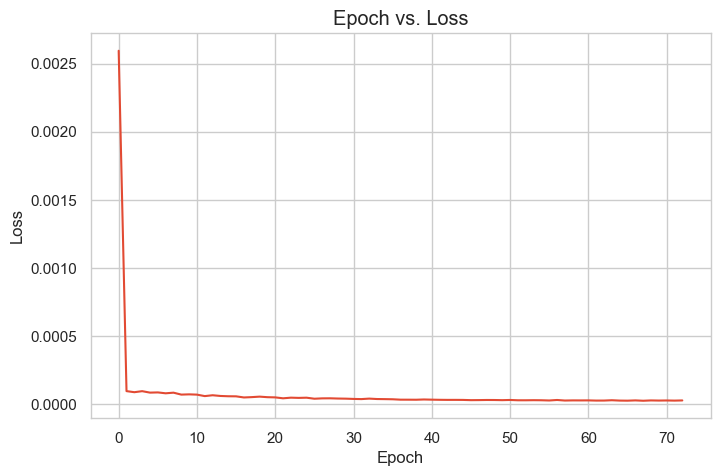

28/28 [==============================] - 0s 3ms/step
Mean Absolute Error (MAE): 21.7896
Mean Absolute Percentage Error (MAPE): 0.5829
Mean Squared Error (MSE): 1377.7237
Root Mean Squared Error (RMSE): 37.1177
R-Pearson Correlation Coefficient (R): 0.9973
R-squared (R2): 0.9945
Program is running for 86 neurons and 4 replicate ----->

Epoch 1/100
439/439 [==============================] - 6s 4ms/step - loss: 0.0040
Epoch 2/100
439/439 [==============================] - 2s 4ms/step - loss: 1.1793e-04
Epoch 3/100
439/439 [==============================] - 2s 4ms/step - loss: 9.8294e-05
Epoch 4/100
439/439 [==============================] - 2s 4ms/step - loss: 9.7589e-05
Epoch 5/100
439/439 [==============================] - 2s 4ms/step - loss: 1.0290e-04
Epoch 6/100
439/439 [==============================] - 2s 4ms/step - loss: 9.7511e-05
Epoch 7/100
439/439 [==============================] - 2s 4ms/step - loss: 9.1506e-05
Epoch 8/100
439/439 [==============================] - 2s 4ms/ste

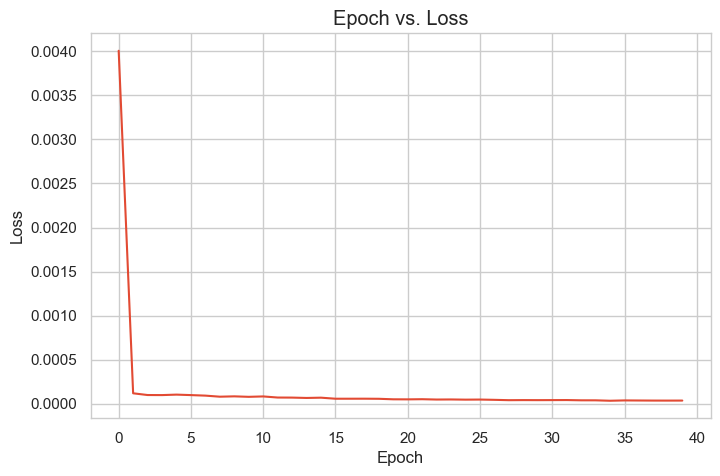

28/28 [==============================] - 0s 3ms/step
Mean Absolute Error (MAE): 29.3298
Mean Absolute Percentage Error (MAPE): 0.7665
Mean Squared Error (MSE): 1656.4795
Root Mean Squared Error (RMSE): 40.6999
R-Pearson Correlation Coefficient (R): 0.9969
R-squared (R2): 0.9934
Program is running for 86 neurons and 5 replicate ----->

Epoch 1/100
439/439 [==============================] - 5s 4ms/step - loss: 0.0080
Epoch 2/100
439/439 [==============================] - 2s 4ms/step - loss: 1.3354e-04
Epoch 3/100
439/439 [==============================] - 2s 4ms/step - loss: 9.0855e-05
Epoch 4/100
439/439 [==============================] - 2s 4ms/step - loss: 8.3059e-05
Epoch 5/100
439/439 [==============================] - 2s 4ms/step - loss: 8.0935e-05
Epoch 6/100
439/439 [==============================] - 2s 4ms/step - loss: 8.1321e-05
Epoch 7/100
439/439 [==============================] - 2s 4ms/step - loss: 8.8407e-05
Epoch 8/100
439/439 [==============================] - 2s 4ms/ste

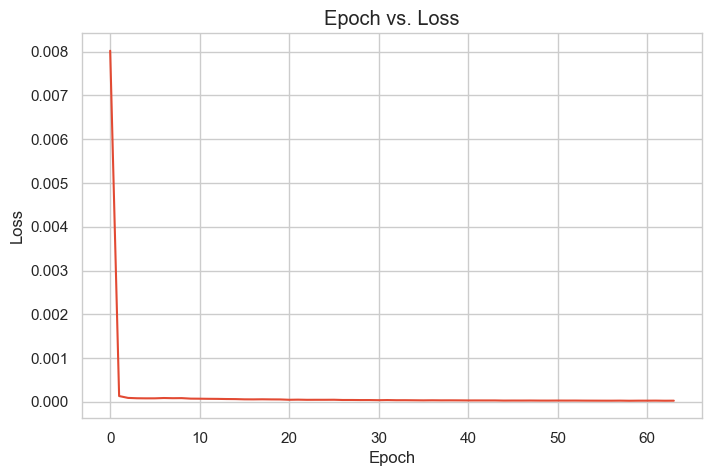

28/28 [==============================] - 0s 4ms/step
Mean Absolute Error (MAE): 26.9239
Mean Absolute Percentage Error (MAPE): 0.7232
Mean Squared Error (MSE): 1627.3785
Root Mean Squared Error (RMSE): 40.3408
R-Pearson Correlation Coefficient (R): 0.9973
R-squared (R2): 0.9935
Program is running for 86 neurons and 6 replicate ----->

Epoch 1/100
439/439 [==============================] - 5s 5ms/step - loss: 0.0039
Epoch 2/100
439/439 [==============================] - 2s 5ms/step - loss: 8.7645e-05
Epoch 3/100
439/439 [==============================] - 2s 5ms/step - loss: 7.4514e-05
Epoch 4/100
439/439 [==============================] - 2s 5ms/step - loss: 7.7375e-05
Epoch 5/100
439/439 [==============================] - 2s 5ms/step - loss: 7.8319e-05
Epoch 6/100
439/439 [==============================] - 2s 5ms/step - loss: 8.4593e-05
Epoch 7/100
439/439 [==============================] - 2s 5ms/step - loss: 7.5235e-05
Epoch 8/100
439/439 [==============================] - 2s 5ms/ste

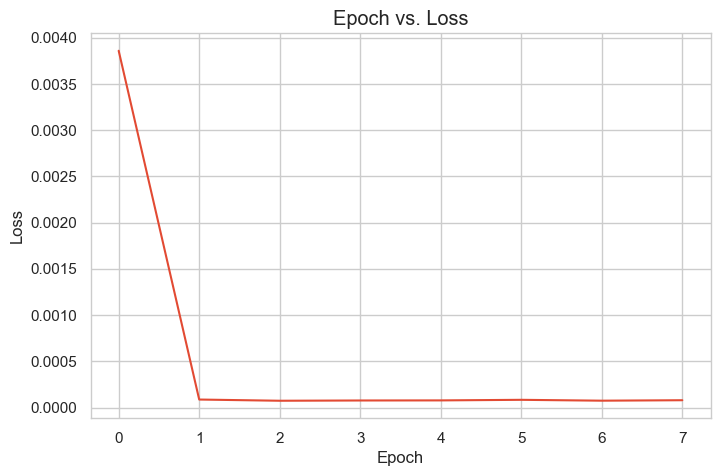

28/28 [==============================] - 0s 4ms/step
Mean Absolute Error (MAE): 41.1397
Mean Absolute Percentage Error (MAPE): 1.0825
Mean Squared Error (MSE): 3169.6114
Root Mean Squared Error (RMSE): 56.2993
R-Pearson Correlation Coefficient (R): 0.9937
R-squared (R2): 0.9874
Program is running for 86 neurons and 7 replicate ----->

Epoch 1/100
439/439 [==============================] - 6s 6ms/step - loss: 0.0015
Epoch 2/100
439/439 [==============================] - 2s 5ms/step - loss: 9.2231e-05
Epoch 3/100
439/439 [==============================] - 2s 5ms/step - loss: 8.8696e-05
Epoch 4/100
439/439 [==============================] - 2s 5ms/step - loss: 8.7502e-05
Epoch 5/100
439/439 [==============================] - 2s 5ms/step - loss: 8.4602e-05
Epoch 6/100
439/439 [==============================] - 2s 5ms/step - loss: 7.8146e-05
Epoch 7/100
439/439 [==============================] - 2s 5ms/step - loss: 6.8353e-05
Epoch 8/100
439/439 [==============================] - 2s 6ms/ste

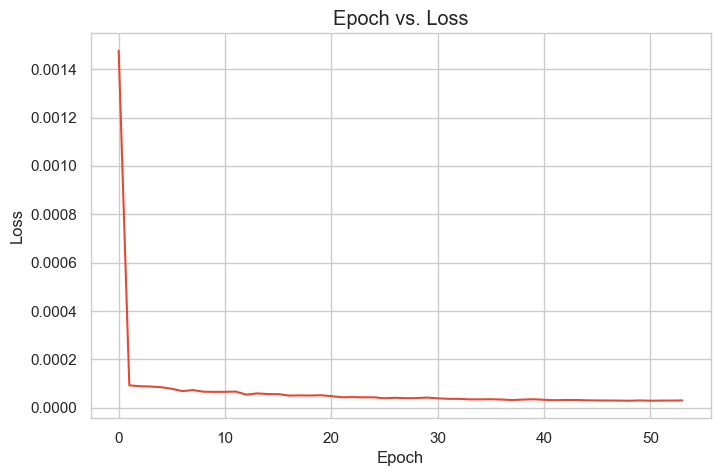

28/28 [==============================] - 0s 4ms/step
Mean Absolute Error (MAE): 23.2345
Mean Absolute Percentage Error (MAPE): 0.6254
Mean Squared Error (MSE): 1427.5818
Root Mean Squared Error (RMSE): 37.7834
R-Pearson Correlation Coefficient (R): 0.9973
R-squared (R2): 0.9943
Program is running for 86 neurons and 8 replicate ----->

Epoch 1/100
439/439 [==============================] - 6s 5ms/step - loss: 0.0044
Epoch 2/100
439/439 [==============================] - 2s 5ms/step - loss: 1.2370e-04
Epoch 3/100
439/439 [==============================] - 2s 5ms/step - loss: 8.8858e-05
Epoch 4/100
439/439 [==============================] - 2s 5ms/step - loss: 9.0340e-05
Epoch 5/100
439/439 [==============================] - 2s 5ms/step - loss: 8.2033e-05
Epoch 6/100
439/439 [==============================] - 2s 5ms/step - loss: 8.5494e-05
Epoch 7/100
439/439 [==============================] - 2s 5ms/step - loss: 8.5932e-05
Epoch 8/100
439/439 [==============================] - 2s 5ms/ste

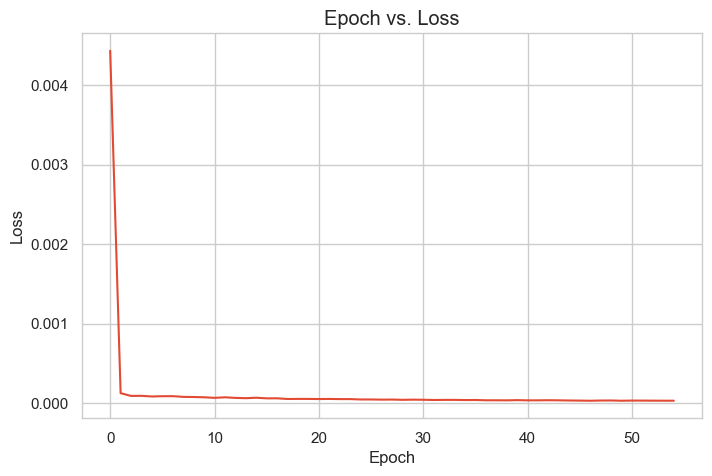

28/28 [==============================] - 0s 4ms/step
Mean Absolute Error (MAE): 20.6008
Mean Absolute Percentage Error (MAPE): 0.5581
Mean Squared Error (MSE): 1331.0618
Root Mean Squared Error (RMSE): 36.4837
R-Pearson Correlation Coefficient (R): 0.9974
R-squared (R2): 0.9947
Program is running for 86 neurons and 9 replicate ----->

Epoch 1/100
439/439 [==============================] - 5s 5ms/step - loss: 0.0033
Epoch 2/100
439/439 [==============================] - 2s 5ms/step - loss: 9.8779e-05
Epoch 3/100
439/439 [==============================] - 2s 5ms/step - loss: 8.3365e-05
Epoch 4/100
439/439 [==============================] - 2s 5ms/step - loss: 9.0720e-05
Epoch 5/100
439/439 [==============================] - 2s 5ms/step - loss: 8.9775e-05
Epoch 6/100
439/439 [==============================] - 2s 5ms/step - loss: 8.3888e-05
Epoch 7/100
439/439 [==============================] - 2s 5ms/step - loss: 7.2260e-05
Epoch 8/100
439/439 [==============================] - 2s 5ms/ste

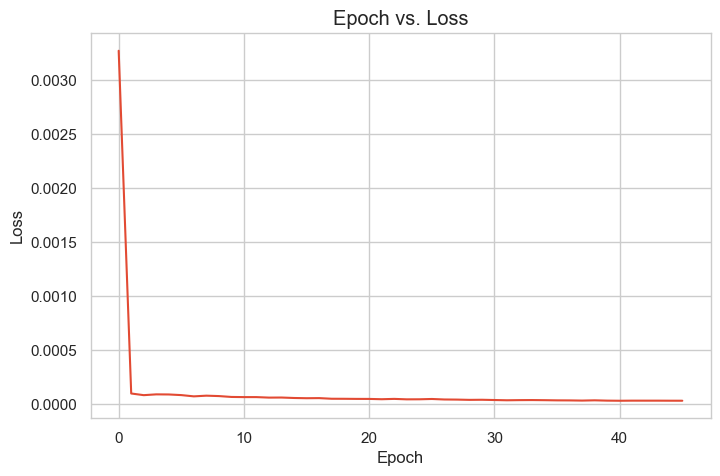

28/28 [==============================] - 0s 4ms/step
Mean Absolute Error (MAE): 24.4613
Mean Absolute Percentage Error (MAPE): 0.6562
Mean Squared Error (MSE): 1407.9317
Root Mean Squared Error (RMSE): 37.5224
R-Pearson Correlation Coefficient (R): 0.9974
R-squared (R2): 0.9944
Program is running for 86 neurons and 10 replicate ----->

Epoch 1/100
439/439 [==============================] - 6s 5ms/step - loss: 0.0027
Epoch 2/100
439/439 [==============================] - 2s 5ms/step - loss: 9.5865e-05
Epoch 3/100
439/439 [==============================] - 2s 5ms/step - loss: 9.6606e-05
Epoch 4/100
439/439 [==============================] - 2s 5ms/step - loss: 9.5416e-05
Epoch 5/100
439/439 [==============================] - 2s 5ms/step - loss: 9.0453e-05
Epoch 6/100
439/439 [==============================] - 2s 5ms/step - loss: 8.5613e-05
Epoch 7/100
439/439 [==============================] - 2s 5ms/step - loss: 8.5994e-05
Epoch 8/100
439/439 [==============================] - 2s 5ms/st

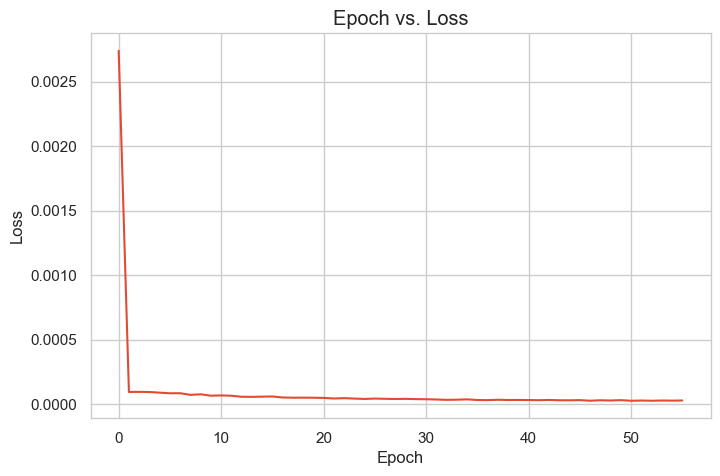

28/28 [==============================] - 0s 4ms/step
Mean Absolute Error (MAE): 23.9083
Mean Absolute Percentage Error (MAPE): 0.6391
Mean Squared Error (MSE): 1421.2862
Root Mean Squared Error (RMSE): 37.6999
R-Pearson Correlation Coefficient (R): 0.9975
R-squared (R2): 0.9944
Program is running for 86 neurons and 11 replicate ----->

Epoch 1/100
439/439 [==============================] - 5s 5ms/step - loss: 0.0028
Epoch 2/100
439/439 [==============================] - 2s 5ms/step - loss: 9.9642e-05
Epoch 3/100
439/439 [==============================] - 2s 5ms/step - loss: 8.9380e-05
Epoch 4/100
439/439 [==============================] - 2s 5ms/step - loss: 9.3771e-05
Epoch 5/100
439/439 [==============================] - 2s 5ms/step - loss: 8.3604e-05
Epoch 6/100
439/439 [==============================] - 2s 5ms/step - loss: 8.2684e-05
Epoch 7/100
439/439 [==============================] - 2s 5ms/step - loss: 7.5317e-05
Epoch 8/100
439/439 [==============================] - 2s 5ms/st

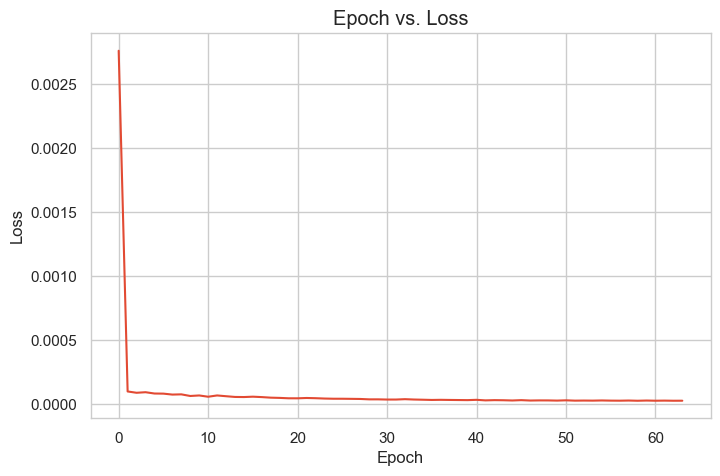

28/28 [==============================] - 0s 4ms/step
Mean Absolute Error (MAE): 20.6943
Mean Absolute Percentage Error (MAPE): 0.5611
Mean Squared Error (MSE): 1313.4433
Root Mean Squared Error (RMSE): 36.2415
R-Pearson Correlation Coefficient (R): 0.9974
R-squared (R2): 0.9948
Program is running for 86 neurons and 12 replicate ----->

Epoch 1/100
439/439 [==============================] - 5s 5ms/step - loss: 0.0027
Epoch 2/100
439/439 [==============================] - 2s 5ms/step - loss: 8.7523e-05
Epoch 3/100
439/439 [==============================] - 2s 5ms/step - loss: 9.3608e-05
Epoch 4/100
439/439 [==============================] - 2s 5ms/step - loss: 9.4303e-05
Epoch 5/100
439/439 [==============================] - 2s 5ms/step - loss: 8.7414e-05
Epoch 6/100
439/439 [==============================] - 2s 5ms/step - loss: 8.7179e-05
Epoch 7/100
439/439 [==============================] - 2s 5ms/step - loss: 7.4692e-05
Epoch 8/100
439/439 [==============================] - 2s 5ms/st

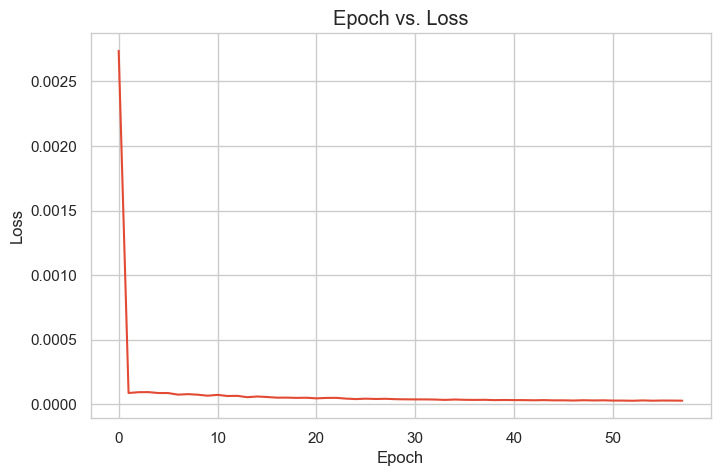

28/28 [==============================] - 0s 4ms/step
Mean Absolute Error (MAE): 23.4927
Mean Absolute Percentage Error (MAPE): 0.6238
Mean Squared Error (MSE): 1421.0989
Root Mean Squared Error (RMSE): 37.6975
R-Pearson Correlation Coefficient (R): 0.9973
R-squared (R2): 0.9944
Program is running for 86 neurons and 13 replicate ----->

Epoch 1/100
439/439 [==============================] - 5s 5ms/step - loss: 0.0030
Epoch 2/100
439/439 [==============================] - 2s 5ms/step - loss: 1.0043e-04
Epoch 3/100
439/439 [==============================] - 2s 5ms/step - loss: 9.2852e-05
Epoch 4/100
439/439 [==============================] - 2s 5ms/step - loss: 8.4301e-05
Epoch 5/100
439/439 [==============================] - 2s 5ms/step - loss: 8.4743e-05
Epoch 6/100
439/439 [==============================] - 2s 5ms/step - loss: 9.1586e-05
Epoch 7/100
439/439 [==============================] - 2s 5ms/step - loss: 8.7400e-05
Epoch 8/100
439/439 [==============================] - 2s 5ms/st

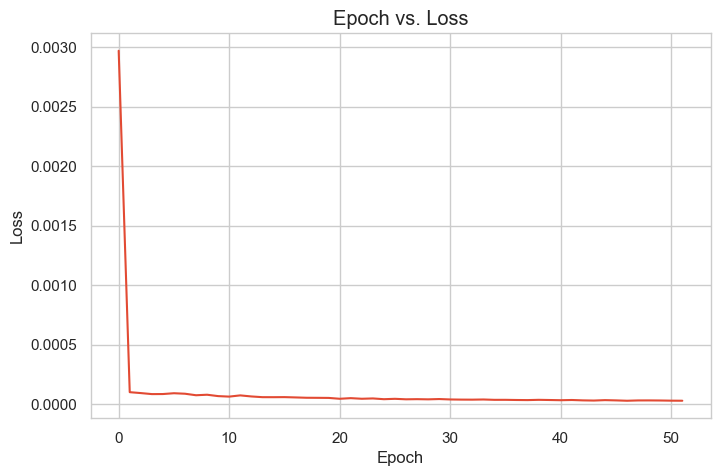

28/28 [==============================] - 0s 4ms/step
Mean Absolute Error (MAE): 22.7315
Mean Absolute Percentage Error (MAPE): 0.6132
Mean Squared Error (MSE): 1426.9813
Root Mean Squared Error (RMSE): 37.7754
R-Pearson Correlation Coefficient (R): 0.9973
R-squared (R2): 0.9943
Program is running for 86 neurons and 14 replicate ----->

Epoch 1/100
439/439 [==============================] - 5s 5ms/step - loss: 0.0061
Epoch 2/100
439/439 [==============================] - 2s 6ms/step - loss: 1.2284e-04
Epoch 3/100
439/439 [==============================] - 2s 5ms/step - loss: 9.1726e-05
Epoch 4/100
439/439 [==============================] - 2s 5ms/step - loss: 9.1119e-05
Epoch 5/100
439/439 [==============================] - 2s 5ms/step - loss: 8.7339e-05
Epoch 6/100
439/439 [==============================] - 2s 5ms/step - loss: 9.5359e-05
Epoch 7/100
439/439 [==============================] - 2s 5ms/step - loss: 8.6747e-05
Epoch 8/100
439/439 [==============================] - 2s 5ms/st

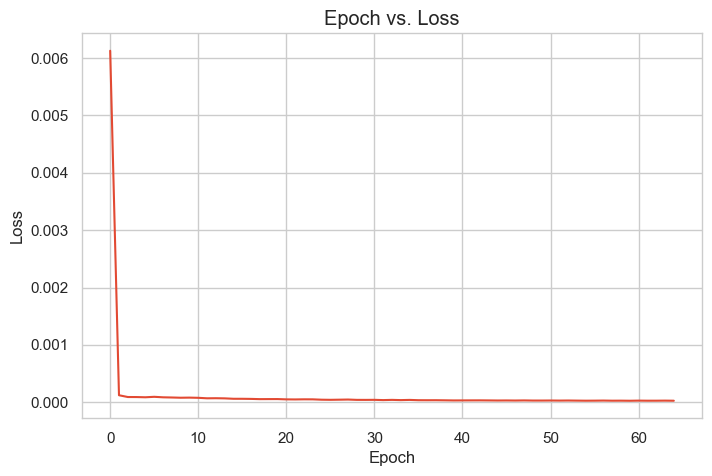

28/28 [==============================] - 0s 4ms/step
Mean Absolute Error (MAE): 27.5271
Mean Absolute Percentage Error (MAPE): 0.7282
Mean Squared Error (MSE): 1707.9808
Root Mean Squared Error (RMSE): 41.3277
R-Pearson Correlation Coefficient (R): 0.9972
R-squared (R2): 0.9932
Progress: Collecting outputs.......


Progress: All works are done successfully, congratulations!!


Best model (neurons, replicate, rmse):  86 11 36.24145876528395

Average scores:
    neurons       rmse      mape         R  elapsed_time
0       86  40.048673  0.687937  0.996946    110.989335

Standard_deviations:
    neurons      rmse      mape         R  elapsed_time
0       86  5.021814  0.130328  0.000954     35.304895

Minimums:
    neurons       rmse      mape         R  elapsed_time
0       86  36.241459  0.558059  0.993719     21.950947

Maximums:
    neurons       rmse      mape         R  elapsed_time
0       86  56.299302  1.082483  0.997459    147.613183


In [61]:
neurons = np.array([neurons])

best_hyper_parameters = [[optimizer, learning_rate, batch_size]]

sl_model_output = single_layer_LSTM(neurons, best_hyper_parameters, data, time_step = 5, test_split = 0.2,
                          epochs = 100, num_replicates = 15)


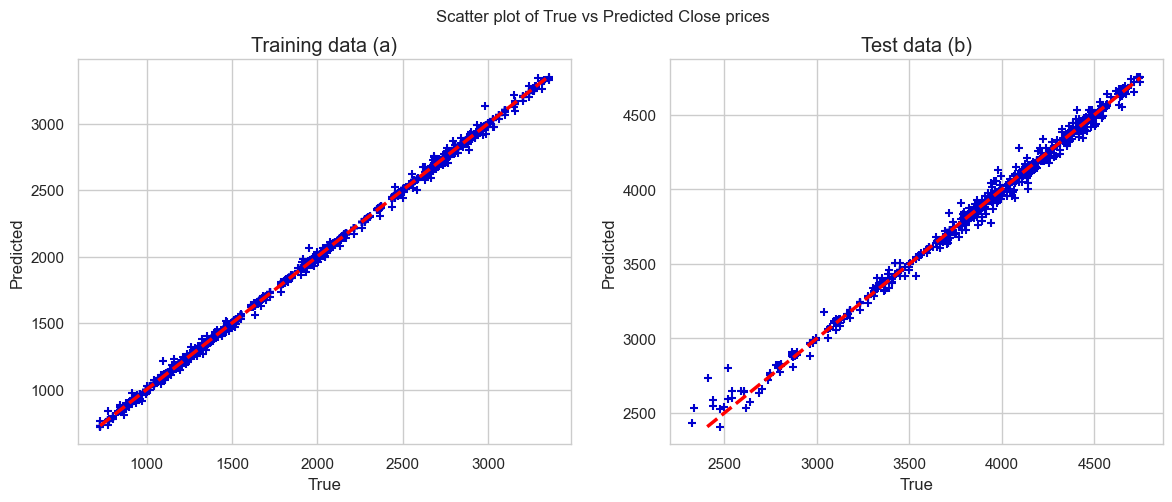

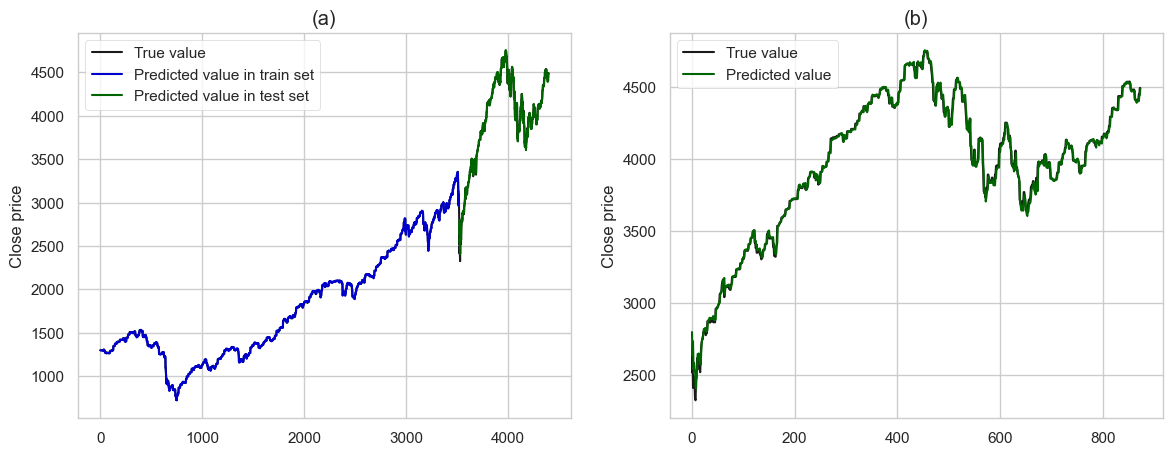

In [62]:
create_visualization(sl_model_output)

In [28]:
import tensorflow as tf
from tensorflow.keras.models import load_model

model = load_model("C:\\Users\\abdur\\Code\\optimized_single_layer_model_11.h5")
model.summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_47 (LSTM)              (None, 86)                33712     
                                                                 
 dense_47 (Dense)            (None, 1)                 87        
                                                                 
Total params: 33799 (132.03 KB)
Trainable params: 33799 (132.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
